In [ ]:
# --------------------------------------- Create by CM ---------------------------------------#


In [73]:
import pandas as pd
import os
import sys
import numpy as np
import re
from pyspark.sql.functions import to_timestamp

from IPython.core.display import display,HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
# %reload_ext sparksql_magic

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [74]:
from termcolor import colored, cprint
# import plotting libraries

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [75]:
class color:
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [76]:
# import dataset
# data file locate in the same directory with code file
print(color.BOLD+'Read file'+color.RED+ ' : live.csv '+color.END)
local_path = os.getcwd()
path_to_file = local_path+'/live.csv'

#Show sample data
print(color.RED+'  print table '+color.END)
df = spark.read.option("header",True).csv(path_to_file)
df.printSchema()
print(df.show(3,False))

Read file : live.csv 
  print table 
root
 |-- status_id: string (nullable = true)
 |-- status_type: string (nullable = true)
 |-- status_published: string (nullable = true)
 |-- num_reactions: string (nullable = true)
 |-- num_comments: string (nullable = true)
 |-- num_shares: string (nullable = true)
 |-- num_likes: string (nullable = true)
 |-- num_loves: string (nullable = true)
 |-- num_wows: string (nullable = true)
 |-- num_hahas: string (nullable = true)
 |-- num_sads: string (nullable = true)
 |-- num_angrys: string (nullable = true)
 |-- Column1: string (nullable = true)
 |-- Column2: string (nullable = true)
 |-- Column3: string (nullable = true)
 |-- Column4: string (nullable = true)

+--------------------------------+-----------+----------------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------+-------+-------+-------+
|status_id                       |status_type|status_published|num_reactions|num_comments|num_shares

In [77]:
# formatted date time column
def udf_split_func(df,col_name1,col_name2,item_no,deli):
    split_col = pyspark.sql.functions.split(df[col_name1], deli)
    output = df.withColumn(col_name2, split_col.getItem(item_no))
    return output

# to date
df = udf_split_func(df,'status_published','date',0,' ')
df = udf_split_func(df,'date','month',0,'/')
df = udf_split_func(df,'date','day',1,'/')
df = udf_split_func(df,'date','year',2,'/')

# to time
df = udf_split_func(df,'status_published','time',1,' ')

df_pd = df.toPandas()
df_pd['date']=(pd.to_datetime(df_pd[['year','month','day']], format='YYYYmmdd'))

# Get hour
df_pd['hour'] =(pd.to_datetime(df_pd['time'], format='%H:%M')).dt.round('H').dt.hour

# get day of week
df_pd['dayofweek']= df_pd['date'].dt.day_name()

df_pd.head(5)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4,date,month,day,year,time,hour,dayofweek
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,None,None,None,None,2018-04-22,4,22,2018,6:00,6,Sunday
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,None,None,None,None,2018-04-21,4,21,2018,22:45,23,Saturday
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,None,None,None,None,2018-04-21,4,21,2018,6:17,6,Saturday
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,None,None,None,None,2018-04-21,4,21,2018,2:29,2,Saturday
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,None,None,None,None,2018-04-18,4,18,2018,3:22,3,Wednesday


# Data Exploration
__1. Check if their is any duplicated rows?, if so remove it__\
__2. Check if their si any status_id duplicates?, if so remove it__\
_(Given assumption that 1 post has 1 status_ID)_ \
&emsp;&emsp;&emsp; -->2 status_id are duplicated, hence removed\  
    
__3. Check if num_reactions wrongly calculated__\
_(Assuming that "num_reactions" is a sum of num_likes,num_loves,num_wows,num_hahasnum_sads,num_angrys)_\
&emsp;&emsp;-->9 rows contains false calculation on "num_reactions", hence correct the sum and updated

__4. Check how many zero in each reaction columns__

In [78]:
## 1. Show Duplicates ##
df_pd[df_pd.duplicated(keep=False)].head(6)

# --- Drop duplicates keep only 1 --- #
df_pd.drop_duplicates(inplace=True)
# --- Drop columns --- #
df_pd.drop(['time', 'month','day','year'
           ,'Column1','Column2','Column3','Column4','status_published'], axis=1, inplace=True)

In [79]:
df_pd.head(3)

,status_id,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,date,hour,dayofweek
0,246675545449582_1649696485147474,video,529,512,262,432,92,3,1,1,0,2018-04-22,6,Sunday
1,246675545449582_1649426988507757,photo,150,0,0,150,0,0,0,0,0,2018-04-21,23,Saturday
2,246675545449582_1648730588577397,video,227,236,57,204,21,1,1,0,0,2018-04-21,6,Saturday


In [80]:
df=spark.createDataFrame(df_pd) 

In [81]:
# 2. Check if there is any status ID duplicate
print(df.groupby(['status_id'])\
.agg(count('status_id').alias('id_cnt'))\
.filter(col('id_cnt')>1)\
.select('status_id','id_cnt').show(10,False))

# Show detail for those 2
dup_id = ['246675545449582_429583263825475','246675545449582_326883450762124']
print(df.filter(col('status_id').isin(dup_id))\
.orderBy('status_id', ascending=False)\
.show(100,False))

# remove it
df = df.filter(~col('status_id').isin(dup_id))
print(df.count())

+-------------------------------+------+
|status_id                      |id_cnt|
+-------------------------------+------+
|246675545449582_429583263825475|2     |
|246675545449582_326883450762124|2     |
+-------------------------------+------+

None
+-------------------------------+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------------------+----+---------+
|status_id                      |status_type|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|date               |hour|dayofweek|
+-------------------------------+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------------------+----+---------+
|246675545449582_429583263825475|photo      |537          |16          |1         |537      |0        |0       |0        |0       |0         |2014-04-22 00:00:00|6   |Tuesday  |
|246675545449582_429583263825475|pho

In [82]:
# 3. Assumption alert ! column "num_reaction indicate the summry of all reactions"
print('Rows contains "num_reactions" and total_reaction mismatched')
tmp_react = ['num_likes','num_loves','num_wows','num_hahas','num_sads','num_angrys']
print(df.withColumn('total', (np.sum(df[col] for col in tmp_react).cast('integer')))\
.filter(col('num_reactions')!=col('total'))\
.select('status_id','status_type','num_reactions','total')\
.show(100,False))

# Correct column "num_reactions"
df = df.withColumn('num_reactions', (np.sum(df[col] for col in tmp_react).cast('integer')))
print(df.count())

Rows contains "num_reactions" and total_reaction mismatched
+--------------------------------+-----------+-------------+-----+
|status_id                       |status_type|num_reactions|total|
+--------------------------------+-----------+-------------+-----+
|246675545449582_1331955210254938|video      |885          |881  |
|246675545449582_1320853268031799|photo      |264          |263  |
|246675545449582_1319907678126358|photo      |313          |310  |
|246675545449582_1319045328212593|photo      |247          |244  |
|246675545449582_1318160668301059|photo      |387          |385  |
|246675545449582_1317164368400689|photo      |178          |176  |
|246675545449582_1316848781765581|photo      |270          |269  |
|246675545449582_1315331711917288|photo      |351          |350  |
|246675545449582_1262985247151935|video      |616          |614  |
+--------------------------------+-----------+-------------+-----+

None
6995


In [83]:
df.show(5,False)

+--------------------------------+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------------------+----+---------+
|status_id                       |status_type|num_reactions|num_comments|num_shares|num_likes|num_loves|num_wows|num_hahas|num_sads|num_angrys|date               |hour|dayofweek|
+--------------------------------+-----------+-------------+------------+----------+---------+---------+--------+---------+--------+----------+-------------------+----+---------+
|246675545449582_1649696485147474|video      |529          |512         |262       |432      |92       |3       |1        |1       |0         |2018-04-22 00:00:00|6   |Sunday   |
|246675545449582_1649426988507757|photo      |150          |0           |0         |150      |0        |0       |0        |0       |0         |2018-04-21 00:00:00|23  |Saturday |
|246675545449582_1648730588577397|video      |227          |236         |57        |204      |21       |1

In [86]:
## 4 Check how many NA rows penetrate to total rows by each column
not_num_col = ['status_id','date','hour','dayofweek']
ttl_rows = int(df.distinct().count())
for i in df.select([i for i in df.columns if i not in 
                       not_num_col]).columns:
    print(color.BOLD+color.BLUE+'Column: '+i+ color.END)
    na_rows_cnt = int(df.filter(col(i)==0).count())
    na_pen = (na_rows_cnt/ttl_rows)*100
    print(color.GREEN+'total unique val: ' ,df.select(i).distinct().count(),color.END)
    print(color.RED+'total NA val: ' ,df.filter(col(i)==0).count(),color.END)
    if na_pen>=50:
        print(color.RED+'More than half is Null ({:.2f}%)'.format(na_pen)+color.END)
        print(df\
              .filter(col(i)==0)\
              .groupby([year('date').alias('year'),'status_type'])\
             .agg(countDistinct('status_id').alias('number of zero'))
             .orderBy('status_type','year', ascending=True)\
             .show(100,False))
        print()
    elif na_pen==0:
        print(color.BLUE+'No NA'+color.END)
        print()
    else:
        print(color.GREEN+'Less than half is Null ({:.2f}%)'.format(na_pen)+color.END)
        print(df\
              .filter(col(i)==0)\
              .groupby([year('date').alias('year'),'status_type'])\
             .agg(countDistinct('status_id').alias('number of zero'))
             .orderBy('status_type','year', ascending=True)\
             .show(100,False))
        print()

Column: status_type
total unique val:  4 
total NA val:  0 
No NA

Column: num_reactions
total unique val:  1067 
total NA val:  121 
Less than half is Null (1.73%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2012|photo      |2             |
|2013|photo      |1             |
|2014|photo      |1             |
|2016|photo      |2             |
|2017|photo      |20            |
|2018|photo      |1             |
|2017|video      |36            |
|2018|video      |58            |
+----+-----------+--------------+

None

Column: num_comments
total unique val:  993 
total NA val:  2119 
Less than half is Null (30.29%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |2             |
|2016|link       |4             |
|2017|link       |11            |
|2018|link       |12            |
|2012|photo      |87            |
|2013|photo      |96            |
|2014|photo      |11            |
|2015|photo      |10            |
|2016|photo      |78            |
|2017|photo      |495           |
|2018|photo      |598           |
|2015|status     |1             |
|2016|status     |6             |
|2017|status     |27            |
|2018|status     |20            |
|2013|video      |11            |
|2014|video      |2             |
|2015|video      |2             |
|2016|video      |10            |
|2017|video      |322           |
|2018|video      |313           |
+----+-----------+--------------+

None

Column: num_shares


total unique val:  501 
total NA val:  3906 
More than half is Null (55.84%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |7             |
|2016|link       |7             |
|2017|link       |7             |
|2018|link       |10            |
|2012|photo      |529           |
|2013|photo      |332           |
|2014|photo      |19            |
|2015|photo      |101           |
|2016|photo      |243           |
|2017|photo      |870           |
|2018|photo      |814           |
|2015|status     |42            |
|2016|status     |34            |
|2017|status     |96            |
|2018|status     |55            |
|2013|video      |34            |
|2014|video      |85            |
|2015|video      |3             |
|2016|video      |54            |
|2017|video      |358           |
|2018|video      |205           |
+----+-----------+--------------+

None

Column: num_likes


total unique val:  1043 
total NA val:  126 
Less than half is Null (1.80%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2012|photo      |2             |
|2013|photo      |1             |
|2014|photo      |1             |
|2016|photo      |2             |
|2017|photo      |23            |
|2018|photo      |1             |
|2017|video      |37            |
|2018|video      |59            |
+----+-----------+--------------+

None

Column: num_loves
total unique val:  229 
total NA val:  4224 
More than half is Null (60.39%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |14            |
|2016|link       |9             |
|2017|link       |10            |
|2018|link       |15            |
|2012|photo      |589           |
|2013|photo      |402           |
|2014|photo      |23            |
|2015|photo      |202           |
|2016|photo      |154           |
|2017|photo      |729           |
|2018|photo      |835           |
|2013|status     |2             |
|2015|status     |79            |
|2016|status     |30            |
|2017|status     |65            |
|2018|status     |39            |
|2013|video      |94            |
|2014|video      |207           |
|2015|video      |42            |
|2016|video      |36            |
|2017|video      |338           |
|2018|video      |309           |
+----+-----------+--------------+

None

Column: num_wows
total unique val:  65 
total NA val:  5293 
More than half

+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |14            |
|2016|link       |11            |
|2017|link       |16            |
|2018|link       |15            |
|2012|photo      |589           |
|2013|photo      |402           |
|2014|photo      |23            |
|2015|photo      |202           |
|2016|photo      |282           |
|2017|photo      |938           |
|2018|photo      |1005          |
|2013|status     |2             |
|2015|status     |79            |
|2016|status     |44            |
|2017|status     |98            |
|2018|status     |60            |
|2013|video      |94            |
|2014|video      |207           |
|2015|video      |42            |
|2016|video      |71            |
|2017|video      |529           |
|2018|video      |569           |
+----+-----------+--------------+

None

Column: num_hahas


total unique val:  42 
total NA val:  5878 
More than half is Null (84.03%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |14            |
|2016|link       |13            |
|2017|link       |18            |
|2018|link       |15            |
|2012|photo      |589           |
|2013|photo      |402           |
|2014|photo      |23            |
|2015|photo      |202           |
|2016|photo      |372           |
|2017|photo      |1198          |
|2018|photo      |1259          |
|2013|status     |2             |
|2015|status     |79            |
|2016|status     |44            |
|2017|status     |115           |
|2018|status     |97            |
|2013|video      |94            |
|2014|video      |207           |
|2015|video      |42            |
|2016|video      |86            |
|2017|video      |488           |
|2018|video      |518           |
+----+-----------+--------------+

None

Column: num_sads


total unique val:  24 
total NA val:  6397 
More than half is Null (91.45%)


+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |14            |
|2016|link       |14            |
|2017|link       |18            |
|2018|link       |16            |
|2012|photo      |589           |
|2013|photo      |402           |
|2014|photo      |23            |
|2015|photo      |202           |
|2016|photo      |369           |
|2017|photo      |1232          |
|2018|photo      |1308          |
|2013|status     |2             |
|2015|status     |79            |
|2016|status     |49            |
|2017|status     |104           |
|2018|status     |90            |
|2013|video      |94            |
|2014|video      |207           |
|2015|video      |42            |
|2016|video      |100           |
|2017|video      |658           |
|2018|video      |784           |
+----+-----------+--------------+

None

Column: num_angrys
total unique val:  14 
total NA val:  6575 
More than ha

+----+-----------+--------------+
|year|status_type|number of zero|
+----+-----------+--------------+
|2014|link       |1             |
|2015|link       |14            |
|2016|link       |14            |
|2017|link       |18            |
|2018|link       |16            |
|2012|photo      |589           |
|2013|photo      |402           |
|2014|photo      |23            |
|2015|photo      |202           |
|2016|photo      |402           |
|2017|photo      |1253          |
|2018|photo      |1334          |
|2013|status     |2             |
|2015|status     |79            |
|2016|status     |51            |
|2017|status     |119           |
|2018|status     |102           |
|2013|video      |94            |
|2014|video      |207           |
|2015|video      |42            |
|2016|video      |108           |
|2017|video      |717           |
|2018|video      |786           |
+----+-----------+--------------+

None



In [87]:

print(df.groupby(['status_type'])\
.agg(countDistinct('status_id').alias('ttl_post')
    ,avg('hour').cast('decimal(12,2)').alias('avg_post_hour')
    ,avg('num_reactions').cast('decimal(12,2)').alias('#react per post')
    ,avg('num_comments').cast('decimal(12,2)').alias('#comment per post')
    ,avg('num_shares').cast('decimal(12,2)').alias('#share per post'))\
.show(100,False))

print(df.groupby(['status_type',year('date').alias('year')])\
.agg(countDistinct('status_id').alias('ttl_post')
    ,avg('hour').cast('decimal(12,2)').alias('avg_post_hour')
    ,avg('num_reactions').cast('decimal(12,2)').alias('avg_ttl_react')
    ,avg('num_comments').cast('decimal(12,2)').alias('avg_comment')
    ,avg('num_shares').cast('decimal(12,2)').alias('avg_shares'))\
.orderBy(['status_type','year'], ascending=True)\
.show(100,False))



+-----------+--------+-------------+---------------+-----------------+---------------+
|status_type|ttl_post|avg_post_hour|#react per post|#comment per post|#share per post|
+-----------+--------+-------------+---------------+-----------------+---------------+
|link       |63      |10.46        |370.14         |5.70             |4.40           |
|status     |359     |7.64         |442.74         |36.43            |2.58           |
|video      |2333    |7.09         |283.37         |642.74           |115.73         |
|photo      |4240    |7.83         |172.14         |15.48            |2.49           |
+-----------+--------+-------------+---------------+-----------------+---------------+

None


+-----------+----+--------+-------------+-------------+-----------+----------+
|status_type|year|ttl_post|avg_post_hour|avg_ttl_react|avg_comment|avg_shares|
+-----------+----+--------+-------------+-------------+-----------+----------+
|link       |2014|1       |23.00        |37.00        |0.00       |0.00      |
|link       |2015|14      |11.79        |1482.07      |14.21      |3.79      |
|link       |2016|14      |11.57        |66.07        |3.29       |5.21      |
|link       |2017|18      |7.83         |67.94        |4.22       |4.78      |
|link       |2018|16      |10.50        |24.06        |2.38       |4.06      |
|photo      |2012|589     |7.60         |21.03        |6.88       |0.19      |
|photo      |2013|402     |7.89         |55.39        |5.00       |0.48      |
|photo      |2014|23      |10.26        |118.78       |3.17       |1.17      |
|photo      |2015|202     |8.95         |1567.73      |37.11      |8.01      |
|photo      |2016|403     |7.66         |198.45     

In [88]:
print(df.groupby([year('date').alias('year')])\
.agg(countDistinct('status_id').alias('ttl_post')
    ,avg('hour').cast('decimal(12,2)').alias('avg_post_hour')
    ,avg('num_reactions').cast('decimal(12,2)').alias('avg_ttl_react')
    ,sum('num_comments').cast('decimal(12,2)').alias('ttl_comments')
    ,avg('num_comments').cast('decimal(12,2)').alias('avg_comment')
    ,sum('num_shares').cast('decimal(12,2)').alias('ttl_shares')
    ,avg('num_shares').cast('decimal(12,2)').alias('avg_shares'))\
.orderBy(['year'], ascending=True)\
.show(100,False))

print(df.groupby([year('date').alias('year'),'dayofweek'])\
.agg(countDistinct('status_id').alias('ttl_post')
    ,avg('hour').cast('decimal(12,2)').alias('avg_post_hour')
    ,avg('num_reactions').cast('decimal(12,2)').alias('avg_ttl_react')
    ,avg('num_comments').cast('decimal(12,2)').alias('avg_comment')
    ,avg('num_shares').cast('decimal(12,2)').alias('avg_shares'))\
.orderBy(['year','dayofweek'], ascending=True)\
.show(100,False))


+----+--------+-------------+-------------+------------+-----------+----------+----------+
|year|ttl_post|avg_post_hour|avg_ttl_react|ttl_comments|avg_comment|ttl_shares|avg_shares|
+----+--------+-------------+-------------+------------+-----------+----------+----------+
|2012|589     |7.60         |21.03        |4053.00     |6.88       |110.00    |0.19      |
|2013|498     |7.88         |89.91        |3000.00     |6.02       |512.00    |1.03      |
|2014|231     |7.85         |609.88       |4605.00     |19.94      |840.00    |3.64      |
|2015|337     |8.02         |1540.18      |11359.00    |33.71      |2936.00   |8.71      |
|2016|588     |7.79         |178.95       |61065.00    |103.85     |4105.00   |6.98      |
|2017|2253    |7.22         |115.07       |731519.00   |324.69     |90793.00  |40.30     |
|2018|2499    |7.74         |196.74       |763002.00   |305.32     |182472.00 |73.02     |
+----+--------+-------------+-------------+------------+-----------+----------+----------+

+----+---------+--------+-------------+-------------+-----------+----------+
|year|dayofweek|ttl_post|avg_post_hour|avg_ttl_react|avg_comment|avg_shares|
+----+---------+--------+-------------+-------------+-----------+----------+
|2012|Friday   |74      |7.00         |22.76        |8.45       |0.24      |
|2012|Monday   |94      |7.57         |21.37        |7.01       |0.26      |
|2012|Saturday |87      |7.46         |20.22        |6.09       |0.18      |
|2012|Sunday   |109     |7.45         |18.44        |5.83       |0.22      |
|2012|Thursday |67      |8.42         |21.82        |7.96       |0.25      |
|2012|Tuesday  |72      |8.83         |21.11        |6.35       |0.08      |
|2012|Wednesday|86      |6.83         |22.62        |7.13       |0.06      |
|2013|Friday   |62      |7.74         |87.87        |8.76       |1.39      |
|2013|Monday   |55      |6.78         |89.89        |5.22       |1.20      |
|2013|Saturday |76      |7.84         |106.00       |5.54       |1.36      |

# Visualisation

In [89]:
sns.set_theme(style="darkgrid")

# df_pd.head()
# drop column "status_id" as student_id is an independent column
corr_df = df_pd.drop(['status_id'],1)
corr_df.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,date,hour,dayofweek
0,video,529,512,262,432,92,3,1,1,0,2018-04-22,6,Sunday
1,photo,150,0,0,150,0,0,0,0,0,2018-04-21,23,Saturday
2,video,227,236,57,204,21,1,1,0,0,2018-04-21,6,Saturday
3,photo,111,0,0,111,0,0,0,0,0,2018-04-21,2,Saturday
4,photo,213,0,0,204,9,0,0,0,0,2018-04-18,3,Wednesday


In [90]:
for i in corr_df.columns:
    corr_df[i] = corr_df[i].astype('category').cat.codes
print(colored(' Show correlation between variables ', 'blue', attrs=['reverse', 'blink']))
corr_df.corr()

 Show correlation between variables 


,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,date,hour,dayofweek
status_type,1.000000,-0.041467,0.110618,0.363201,-0.046772,0.287596,0.114165,0.364957,0.167417,0.184277,0.220021,-0.058425,-0.002142
num_reactions,-0.041467,1.000000,0.058254,0.031489,0.862936,-0.013176,0.058394,-0.009648,0.022132,-0.010921,0.003230,0.017962,-0.006382
num_comments,0.110618,0.058254,1.000000,0.231067,0.058003,0.331771,0.210351,0.193362,0.084990,0.097400,-0.139590,-0.018302,0.016719
num_shares,0.363201,0.031489,0.231067,1.000000,0.010945,0.375624,0.272595,0.349363,0.178301,0.212534,0.178171,0.000865,-0.001574
num_likes,-0.046772,0.862936,0.058003,0.010945,1.000000,-0.015738,0.057852,-0.022322,0.007334,0.004914,0.005621,0.018061,-0.006358
num_loves,0.287596,-0.013176,0.331771,0.375624,-0.015738,1.000000,0.387790,0.388546,0.203687,0.154611,0.285206,-0.039308,0.014178
num_wows,0.114165,0.058394,0.210351,0.272595,0.057852,0.387790,1.000000,0.313272,0.244802,0.240572,0.205894,0.014585,-0.003685
num_hahas,0.364957,-0.009648,0.193362,0.349363,-0.022322,0.388546,0.313272,1.000000,0.292999,0.354731,0.199244,-0.017859,0.002687
num_sads,0.167417,0.022132,0.084990,0.178301,0.007334,0.203687,0.244802,0.292999,1.000000,0.238165,0.098840,0.025804,0.012338
num_angrys,0.184277,-0.010921,0.097400,0.212534,0.004914,0.154611,0.240572,0.354731,0.238165,1.000000,0.122814,-0.007944,-0.011728


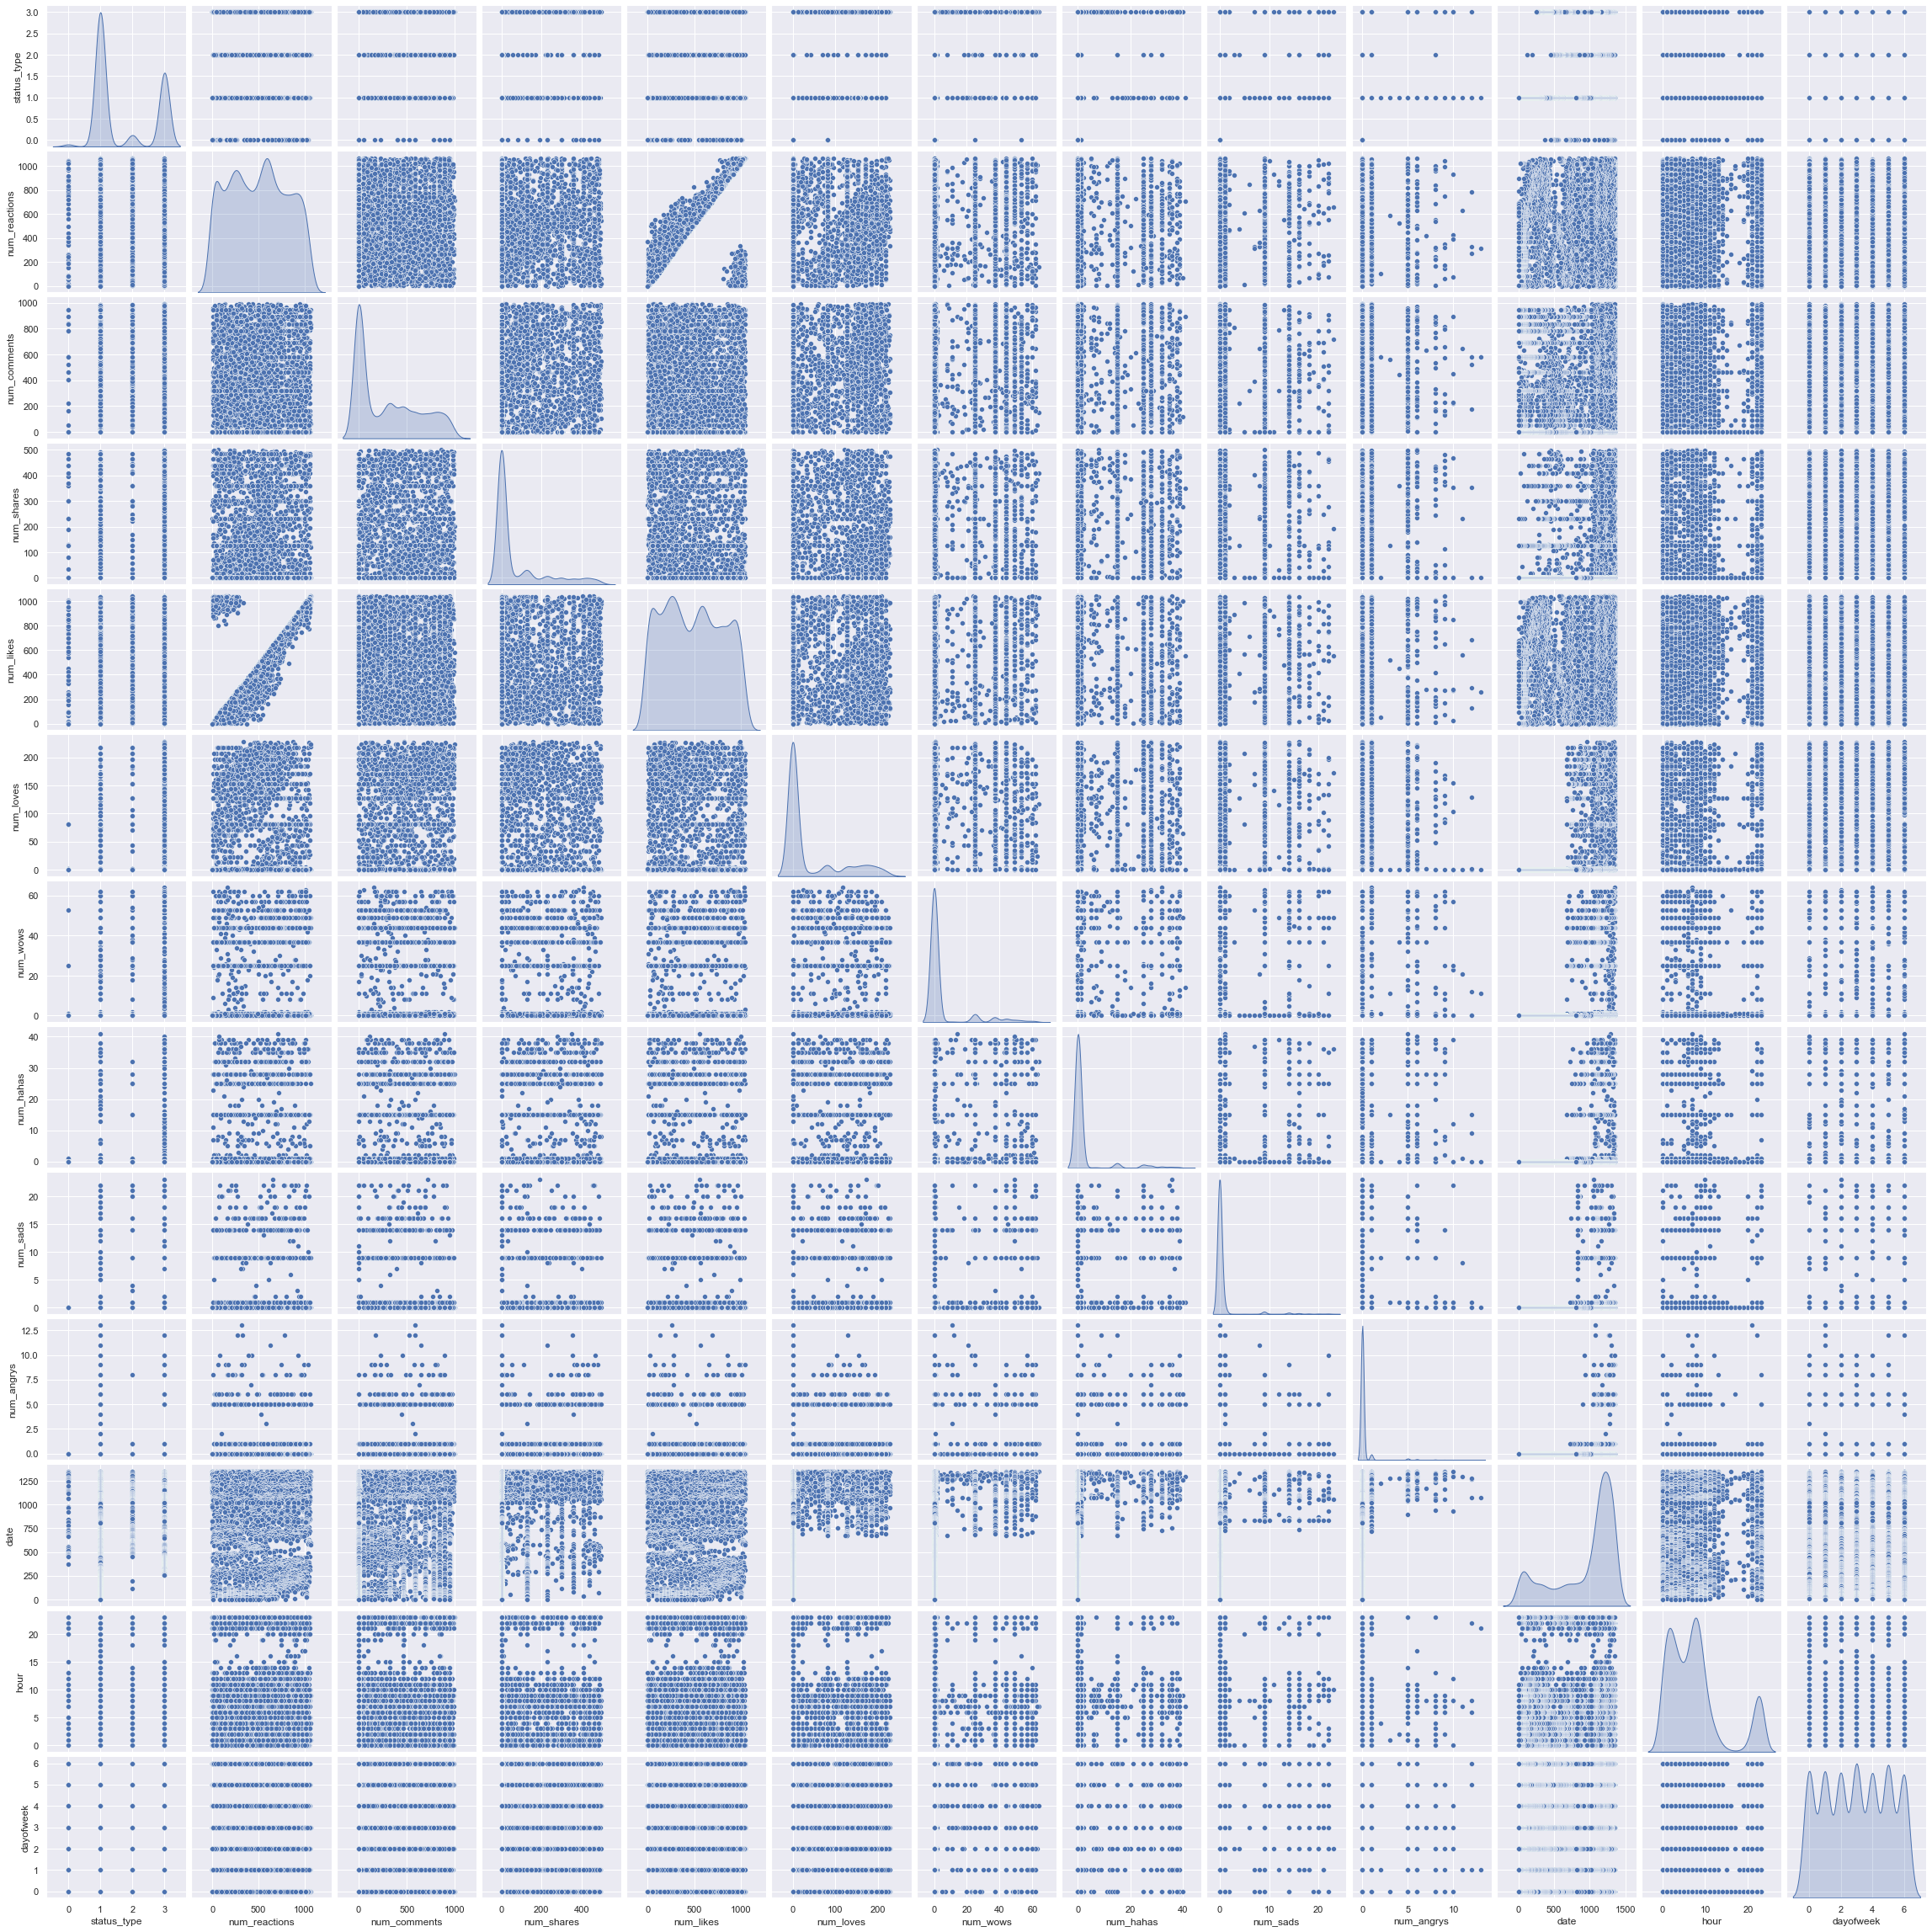

In [91]:
# plot between variables
sns.pairplot(corr_df, diag_kind='kde')

 Show correlation between variables - heatmap 


<AxesSubplot:>

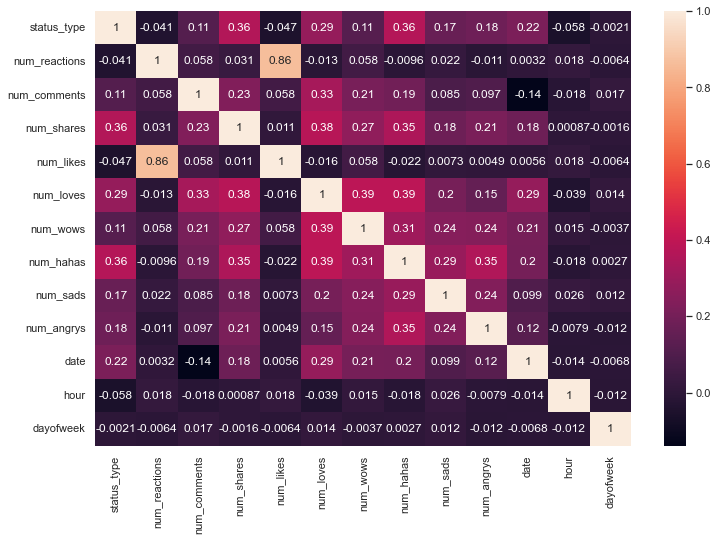

In [92]:
# more relation score between number of likes and  number of reactions
print(colored(' Show correlation between variables - heatmap ', 'blue', attrs=['reverse', 'blink']))

plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(),annot=True)

* from correlation plot above suggests that
    * number of share and comments relates to the number of people who click on positive reactions (loves, wows, hahas).
    * There is an association shows between status type and number of shares; posts with visual tends to be more shared than link or status

<AxesSubplot:xlabel='status_type', ylabel='count'>

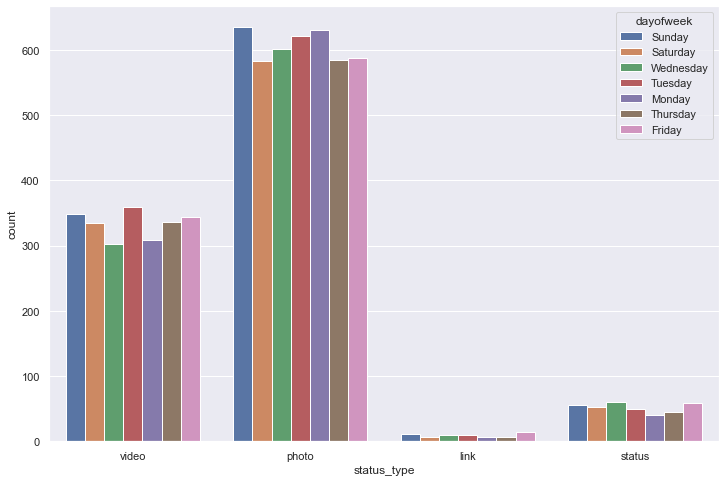

In [93]:
# number of post across day of week
plt.figure(figsize=(12,8))
sns.countplot(x="status_type", hue='dayofweek', data=df_pd)

<AxesSubplot:xlabel='status_type', ylabel='count'>

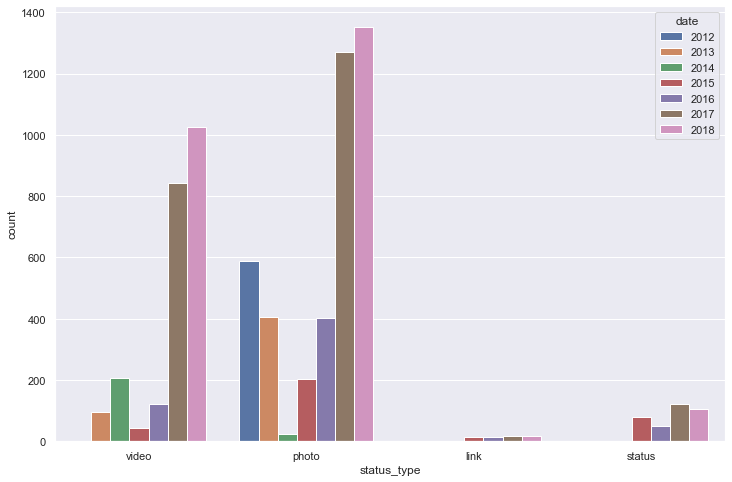

In [94]:
# number of post throughout the year
plt.figure(figsize=(12,8))
sns.countplot(hue=df_pd['date'].dt.year, x='status_type', data=df_pd)

* Majority of posted contents are photos
    * Sunday and Monday has the most photos post especially in 2017-2018
* Video contents become more popular since 2017, and it most posted on Tueesday and Sunday

No handles with labels found to put in legend.


[Text(0.5, 1.0, 'Number of post in 2012')]

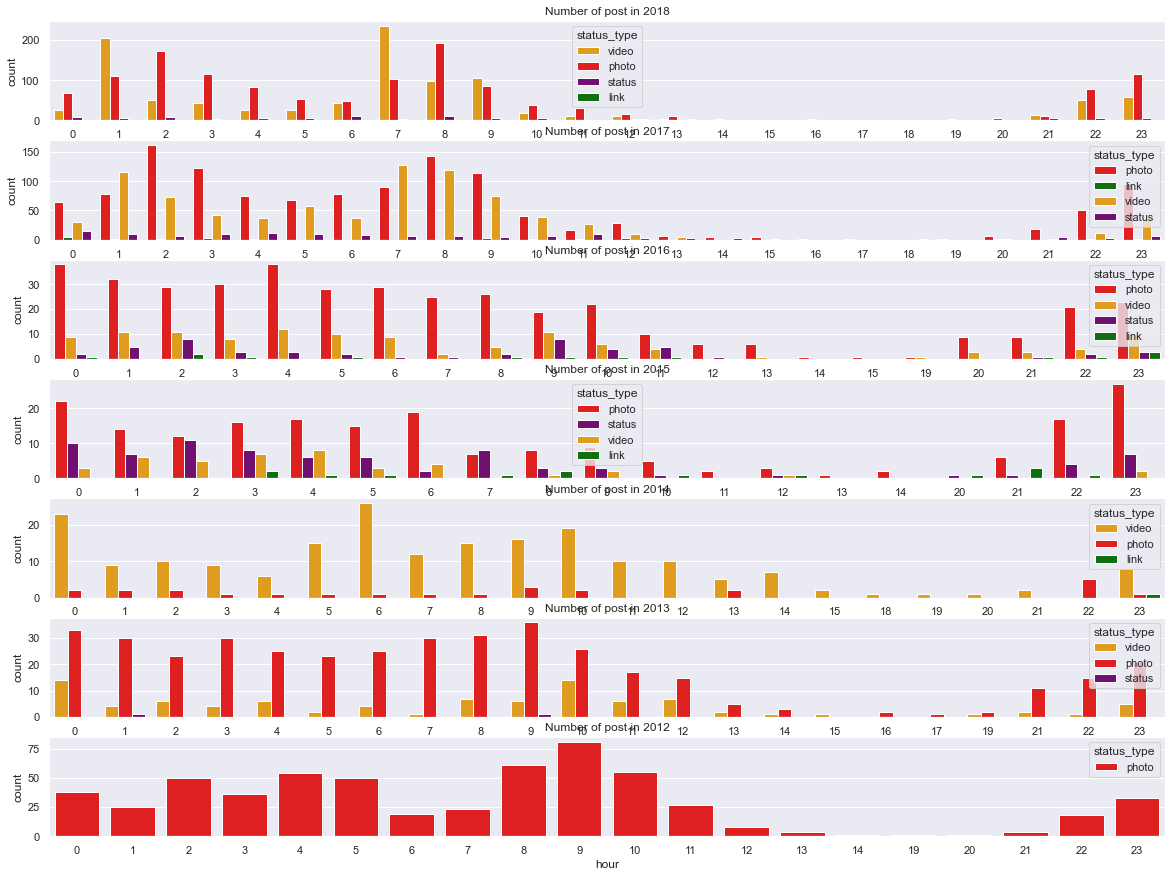

In [95]:
# number of post in terms of posting time

colors = {'photo':'red', 'video':'orange', 'status':'purple', 'link':'green'}
fig, axs = plt.subplots(nrows=7,figsize=(20,15))
plt.legend(loc='upper left')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2018]
              , ax=axs[0],palette=colors,).set(title='Number of post in 2018')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2017]
              , ax=axs[1],palette=colors).set(title='Number of post in 2017')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2016]
              , ax=axs[2],palette=colors).set(title='Number of post in 2016')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2015]
              , ax=axs[3],palette=colors).set(title='Number of post in 2015')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2014]
              , ax=axs[4],palette=colors).set(title='Number of post in 2014')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2013]
              , ax=axs[5],palette=colors).set(title='Number of post in 2013')
sns.countplot(x='hour', hue='status_type', data=df_pd[df_pd['date'].dt.year==2012]
              , ax=axs[6],palette=colors).set(title='Number of post in 2012')

<AxesSubplot:xlabel='hour', ylabel='count'>

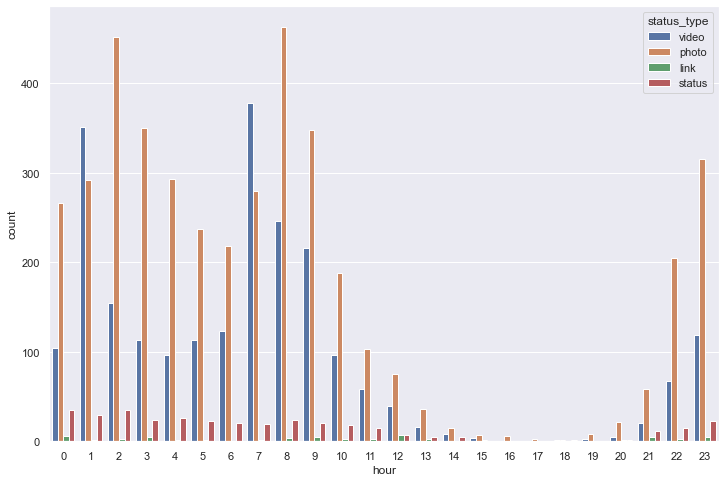

In [96]:
#see hour vs status type
plt.figure(figsize=(12,8))
sns.countplot(hue='status_type', x='hour', data=df_pd)

# Model fitting - Predict "Engagement matric - num_reactions"


In [97]:
corr_df.head(3)

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,date,hour,dayofweek
0,3,834,704,191,732,221,37,1,1,0,1299,6,3
1,1,213,0,0,215,0,0,0,0,0,1298,23,2
2,3,463,372,396,369,87,1,1,0,0,1298,6,2


In [98]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn import metrics


 __Model Quality Matrics:__
 * Accuracy: telss how well the model perform
 * Explain variance score :how well model can account for the variation
 * R2 : tells how well the unknown samples will be predicted by the model

In [103]:
x = corr_df.drop(['dayofweek','num_reactions','hour','date'
                  ,'num_hahas'],axis=1)
# x = corr_df
y = corr_df['num_reactions']

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 123)

In [106]:
#LinearRegression
lr = LinearRegression()
#training the model on training data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(lr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 72.78%
Explain variance score : 0.73
R2 score: 0.73


In [109]:
#GradientBoostingRegressor
gradientBoost = GradientBoostingRegressor(random_state=1234,learning_rate=0.03, n_estimators=300)
gradientBoost.fit(X_train,y_train)
y_pred = gradientBoost.predict(X_test)


print('Accuracy - LinearRegression: %.2f%%'%(gradientBoost.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 88.64%
Explain variance score : 0.89
R2 score: 0.89


In [110]:
#random forest regression

regr = RandomForestRegressor(max_depth=500, random_state=0, n_estimators=300)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(regr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 92.91%
Explain variance score : 0.93
R2 score: 0.93


Please note that the accuracy score for number of reactions is high, due to given the assumption that it is a combination of all interaction button (likes, love, hahas, sads , angrys, wows).

# Model fitting - Predict "Engagement matric - num_comments"


In [139]:
x = corr_df.drop(['num_comments'],axis=1)
# x = corr_df
y = corr_df['num_comments']

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 123)

In [140]:
#LinearRegression
lr = LinearRegression()
#training the model on training data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(lr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 16.71%
Explain variance score : 0.17
R2 score: 0.17


In [141]:
#GradientBoostingRegressor
gradientBoost = GradientBoostingRegressor(random_state=1234,learning_rate=0.03, n_estimators=300)
gradientBoost.fit(X_train,y_train)
y_pred = gradientBoost.predict(X_test)


print('Accuracy - LinearRegression: %.2f%%'%(gradientBoost.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 24.70%
Explain variance score : 0.25
R2 score: 0.25


In [144]:
#random forest regression

regr = RandomForestRegressor(max_depth=500, random_state=0, n_estimators=1500)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(regr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 25.14%
Explain variance score : 0.25
R2 score: 0.25


# Model fitting - Predict "Engagement matric - num_shares"
Since we do not know the detail of contents, it might be hard to estimate the number of shares and comments if we only have to based on number of interaction in each post.


In [145]:
x = corr_df.drop(['num_shares'],axis=1)
# x = corr_df
y = corr_df['num_shares']

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 123)

In [146]:
#LinearRegression
lr = LinearRegression()
#training the model on training data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(lr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - LinearRegression: 24.81%
Explain variance score : 0.25
R2 score: 0.25


In [157]:
#GradientBoostingRegressor
gradientBoost = GradientBoostingRegressor(random_state=1234,learning_rate=0.06, n_estimators=900)
gradientBoost.fit(X_train,y_train)
y_pred = gradientBoost.predict(X_test)


print('Accuracy - gradientBoost: %.2f%%'%(gradientBoost.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - gradientBoost: 37.97%
Explain variance score : 0.38
R2 score: 0.38


In [156]:
#random forest regression

regr = RandomForestRegressor(max_depth=700, random_state=0, n_estimators=1500)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

print('Accuracy - RandomForestRegressor: %.2f%%'%(regr.score(X_test,y_test)*100))
print("Explain variance score : %.2f"% metrics.explained_variance_score(y_test, y_pred)) 
print("R2 score: %.2f"% metrics.r2_score(y_test, y_pred))

Accuracy - RandomForestRegressor: 38.65%
Explain variance score : 0.39
R2 score: 0.39
